In [5]:
import json
import math
import random
import gc
import torch
import os
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, field
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import logging
from contextlib import contextmanager
from IPython.display import clear_output
import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


In [6]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

print("✅ Imports complete!")
print(f"🎮 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

✅ Imports complete!
🎮 CUDA Available: False


In [7]:
@dataclass
class ReasoningNode:
    """MCTS Node representing one step in reasoning chain"""
    reasoning_step: str
    confidence_score: float = 0.0
    visit_count: int = 0
    value_sum: float = 0.0
    children: List['ReasoningNode'] = field(default_factory=list)
    parent: Optional['ReasoningNode'] = None
    is_terminal: bool = False
    
    def ucb_score(self, exploration_weight: float = 1.4) -> float:
        """Calculate UCB (Upper Confidence Bound) score for node selection"""
        if self.visit_count == 0:
            return float('inf')
        
        exploitation = self.value_sum / self.visit_count
        if self.parent and self.parent.visit_count > 0:
            exploration = math.sqrt(math.log(self.parent.visit_count) / self.visit_count)
        else:
            exploration = 0
        return exploitation + exploration_weight * exploration
    
    def is_fully_expanded(self, max_children: int = 3) -> bool:  # Reduced from 5
        """Check if node has been fully expanded"""
        return len(self.children) >= max_children or self.is_terminal

class MCTSReasoningEngine:
    """MCTS-based reasoning chain generator for academic visual reasoning"""
    
    def __init__(self, model_name: str = "microsoft/DialoGPT-medium", use_lightweight: bool = True):
        logger.info(f"Initializing MCTS Engine with model: {model_name}")
        
        # Use lighter model and configuration for stability
        self.model_name = model_name
        self.use_lightweight = use_lightweight
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Initialize model with better memory management
        self._initialize_model()
        
        # Reduced MCTS parameters for stability
        self.max_iterations = 20  # Reduced from 50
        self.max_depth = 5       # Reduced from 8
        self.exploration_weight = 1.4
        
        # Pre-defined reasoning templates (no LLM needed)
        self.reasoning_templates = {
            "professional_entity_location": [
                "Analyze the professional context and domain",
                "Identify key organizations or institutions mentioned", 
                "Match entity characteristics with domain knowledge",
                "Verify entity relevance to the scenario"
            ],
            "multimodal_temporal_reasoning": [
                "Identify temporal markers and sequences",
                "Analyze chronological relationships",
                "Connect timing with context",
                "Validate temporal consistency"
            ],
            "cross_subgraph_role_reasoning": [
                "Identify system components", 
                "Analyze component relationships",
                "Understand component roles",
                "Map system interactions"
            ],
            "causal_mechanism_reasoning": [
                "Identify cause-effect relationships",
                "Trace causal pathways",
                "Analyze mechanisms",
                "Verify causal logic"
            ],
            "methodological_technical_reasoning": [
                "Identify technical methods",
                "Analyze method characteristics",
                "Evaluate method appropriateness",
                "Validate technical accuracy"
            ]
        }

    def _initialize_model(self):
        """Initialize model with proper memory management"""
        try:
            if self.use_lightweight:
                # Use a more stable, lighter approach
                self.tokenizer = None
                self.model = None
                self.reasoning_generator = None
                logger.info("Using lightweight mode - no LLM loading")
            else:
                # Load model with better configuration
                self.tokenizer = AutoTokenizer.from_pretrained(
                    self.model_name,
                    padding_side='left',
                    cache_dir='./model_cache'
                )
                
                self.model = AutoModelForCausalLM.from_pretrained(
                    self.model_name,
                    torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
                    low_cpu_mem_usage=True,
                    cache_dir='./model_cache',
                    device_map="auto" if self.device == "cuda" else None
                )
                
                if self.tokenizer.pad_token is None:
                    self.tokenizer.pad_token = self.tokenizer.eos_token
                
                self.reasoning_generator = pipeline(
                    "text-generation",
                    model=self.model,
                    tokenizer=self.tokenizer,
                    max_new_tokens=50,  # Reduced
                    temperature=0.7,
                    do_sample=True,
                    device=0 if self.device == "cuda" else -1,
                    batch_size=1
                )
                
                logger.info(f"Model loaded successfully on {self.device}")
                
        except Exception as e:
            logger.error(f"Error loading model: {e}")
            logger.info("Falling back to lightweight mode")
            self.use_lightweight = True
            self.reasoning_generator = None

    @contextmanager
    def memory_cleanup(self):
        """Context manager for memory cleanup"""
        try:
            yield
        finally:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

    def generate_thought_chain(self, question_data: Dict) -> Dict:
        """Main entry point: Generate reasoning chain for a question using MCTS"""
        
        with self.memory_cleanup():
            logger.info(f"Generating chain for: {question_data.get('reasoning_type', 'unknown')}")
            
            # Initialize root node
            root = ReasoningNode(
                reasoning_step=f"Question: {question_data['gapped_text']}",
                confidence_score=1.0
            )
            
            # Run MCTS iterations with progress tracking
            for iteration in range(self.max_iterations):
                if iteration % 5 == 0:
                    logger.debug(f"MCTS iteration {iteration}/{self.max_iterations}")
                
                try:
                    # (a) Selection: Find best node to expand
                    selected_node = self.select_node(root)
                    
                    # (b) Expansion: Add new reasoning step
                    if not selected_node.is_fully_expanded():
                        new_node = self.expand_node(selected_node, question_data)
                        if new_node:
                            selected_node = new_node
                    
                    # (c) Simulation: Complete reasoning chain and evaluate
                    simulation_value = self.simulate_reasoning(selected_node, question_data)
                    
                    # (d) Backpropagation: Update node values
                    self.backpropagate(selected_node, simulation_value)
                    
                except Exception as e:
                    logger.warning(f"Error in MCTS iteration {iteration}: {e}")
                    continue
            
            # Extract best reasoning chain
            best_chain = self.extract_best_chain(root)
            
            return {
                "question_id": question_data.get("question_id", f"q_{random.randint(1000, 9999)}"),
                "reasoning_type": question_data["reasoning_type"],
                "question": question_data["gapped_text"],
                "answers": question_data["answers"],
                "thought_chain": best_chain,
                "reasoning_quality_score": self.evaluate_chain_quality(best_chain, question_data),
                "mcts_iterations": self.max_iterations,
                "mcts_exploration_depth": len(best_chain)
            }

    def select_node(self, root: ReasoningNode) -> ReasoningNode:
        """(a) Selection: Select most promising node using UCB"""
        current = root
        depth = 0
        
        while current.children and current.is_fully_expanded() and depth < self.max_depth:
            # Select child with highest UCB score
            try:
                best_child = max(current.children, key=lambda child: child.ucb_score(self.exploration_weight))
                current = best_child
                depth += 1
            except ValueError:
                break
        
        return current

    def expand_node(self, node: ReasoningNode, question_data: Dict) -> Optional[ReasoningNode]:
        """(b) Expansion: Add new reasoning step as child node"""
        
        # Don't expand beyond max depth
        current_depth = self.get_node_depth(node)
        if current_depth >= self.max_depth:
            node.is_terminal = True
            return None
        
        # Generate next reasoning step
        reasoning_type = question_data["reasoning_type"]
        current_chain = self.get_chain_to_node(node)
        
        next_step = self.generate_next_reasoning_step_template(
            current_chain, 
            question_data, 
            reasoning_type
        )
        
        if next_step:
            # Create new child node
            child_node = ReasoningNode(
                reasoning_step=next_step,
                parent=node,
                is_terminal=(current_depth >= self.max_depth - 1)
            )
            
            node.children.append(child_node)
            return child_node
        
        return None

    def generate_next_reasoning_step_template(self, current_chain: List[str], question_data: Dict, reasoning_type: str) -> str:
        """Generate next reasoning step using templates (no LLM required)"""
        
        # Get template steps for this reasoning type
        template_steps = self.reasoning_templates.get(reasoning_type, [])
        current_step_index = len(current_chain) - 1  # Subtract 1 for initial question
        
        if current_step_index < len(template_steps):
            # Use template-based reasoning
            template_step = template_steps[current_step_index]
            
            # Customize template with question context
            customized_step = self.customize_reasoning_step(
                template_step, 
                question_data
            )
            
            return customized_step
        else:
            # Generate fallback reasoning step
            return self.generate_fallback_reasoning_step(current_chain, question_data)

    def customize_reasoning_step(self, template_step: str, question_data: Dict) -> str:
        """Customize template reasoning step with question-specific details"""
        
        reasoning_type = question_data["reasoning_type"]
        answers = question_data.get("answers", [])
        
        # Customize based on reasoning type
        if reasoning_type == "professional_entity_location":
            if "organizations" in template_step.lower():
                return f"Consider organizations like {', '.join(answers[:2])} that are relevant to this domain"
        
        elif reasoning_type == "methodological_technical_reasoning":
            if "technical" in template_step.lower():
                return f"Analyze the technical methods: {', '.join(answers[:2])} and their applications"
        
        elif reasoning_type == "multimodal_temporal_reasoning":
            if "temporal" in template_step.lower():
                return f"Examine the time-related information: {', '.join(answers[:2])}"
        
        elif reasoning_type == "causal_mechanism_reasoning":
            if "cause" in template_step.lower():
                return f"Trace how {answers[0] if answers else 'input'} leads to the described outcome"
        
        elif reasoning_type == "cross_subgraph_role_reasoning":
            if "components" in template_step.lower():
                return f"Analyze the structural elements: {', '.join(answers[:2])} and their relationships"
        
        return template_step

    def generate_fallback_reasoning_step(self, current_chain: List[str], question_data: Dict) -> str:
        """Generate fallback reasoning step without LLM"""
        
        fallback_steps = [
            "Review the established context and relationships",
            "Validate the logical consistency of the reasoning",
            "Consider alternative explanations or approaches",
            "Synthesize the information to reach a conclusion"
        ]
        
        step_index = (len(current_chain) - 1) % len(fallback_steps)
        return fallback_steps[step_index]

    def simulate_reasoning(self, node: ReasoningNode, question_data: Dict) -> float:
        """(c) Simulation: Complete reasoning chain and evaluate quality"""
        
        # Get current chain
        current_chain = self.get_chain_to_node(node)
        
        # If terminal node, evaluate current chain
        if node.is_terminal or len(current_chain) >= self.max_depth:
            return self.evaluate_chain_quality(current_chain, question_data)
        
        # Otherwise, simulate completion with template steps
        simulated_chain = current_chain.copy()
        reasoning_type = question_data["reasoning_type"]
        
        while len(simulated_chain) < self.max_depth:
            # Add a simulated reasoning step
            next_step = self.generate_next_reasoning_step_template(
                simulated_chain, 
                question_data, 
                reasoning_type
            )
            simulated_chain.append(next_step)
            
            # Random chance to terminate early
            if random.random() < 0.4:  # Increased chance for shorter chains
                break
        
        return self.evaluate_chain_quality(simulated_chain, question_data)

    def evaluate_chain_quality(self, reasoning_chain: List[str], question_data: Dict) -> float:
        """Evaluate quality of reasoning chain (0-1 score)"""
        
        if len(reasoning_chain) <= 1:  # Just the question
            return 0.1
        
        score = 0.0
        reasoning_steps = reasoning_chain[1:]  # Exclude initial question
        
        # Factor 1: Chain length (optimal around 3-4 steps)
        optimal_length = 4
        length_score = 1.0 - abs(len(reasoning_steps) - optimal_length) / optimal_length
        length_score = max(0, min(1, length_score))
        score += 0.25 * length_score
        
        # Factor 2: Reasoning type alignment
        reasoning_type = question_data["reasoning_type"]
        template_steps = self.reasoning_templates.get(reasoning_type, [])
        
        alignment_score = 0.0
        for i, step in enumerate(reasoning_steps):
            if i < len(template_steps):
                # Check if step follows template logic
                template_keywords = template_steps[i].lower().split()
                step_keywords = step.lower().split()
                overlap = len(set(template_keywords) & set(step_keywords))
                alignment_score += overlap / max(len(template_keywords), 1)
        
        if len(reasoning_steps) > 0:
            alignment_score /= len(reasoning_steps)
        score += 0.35 * alignment_score
        
        # Factor 3: Answer relevance
        answers = question_data.get("answers", [])
        answer_mentions = 0
        for answer in answers:
            for step in reasoning_steps:
                if answer.lower() in step.lower():
                    answer_mentions += 1
                    break
        
        answer_relevance = answer_mentions / max(len(answers), 1)
        score += 0.3 * answer_relevance
        
        # Factor 4: Logical progression
        progression_score = 0.8  # Default good progression
        score += 0.1 * progression_score
        
        return min(1.0, score)

    def backpropagate(self, node: ReasoningNode, value: float):
        """(d) Backpropagation: Update node statistics"""
        
        current = node
        while current is not None:
            current.visit_count += 1
            current.value_sum += value
            current = current.parent

    def extract_best_chain(self, root: ReasoningNode) -> List[str]:
        """Extract the best reasoning chain from MCTS tree"""
        
        chain = [root.reasoning_step]
        current = root
        
        while current.children:
            # Select child with highest average value
            best_child = max(
                current.children, 
                key=lambda child: child.value_sum / max(child.visit_count, 1)
            )
            chain.append(best_child.reasoning_step)
            current = best_child
        
        return chain

    def get_chain_to_node(self, node: ReasoningNode) -> List[str]:
        """Get reasoning chain from root to given node"""
        chain = []
        current = node
        
        while current is not None:
            chain.insert(0, current.reasoning_step)
            current = current.parent
        
        return chain

    def get_node_depth(self, node: ReasoningNode) -> int:
        """Get depth of node in tree"""
        depth = 0
        current = node.parent
        
        while current is not None:
            depth += 1
            current = current.parent
        
        return depth

    def cleanup(self):
        """Clean up model and free memory"""
        if hasattr(self, 'model') and self.model:
            del self.model
        if hasattr(self, 'tokenizer') and self.tokenizer:
            del self.tokenizer
        if hasattr(self, 'reasoning_generator') and self.reasoning_generator:
            del self.reasoning_generator
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        logger.info("Model cleanup completed")



In [8]:
def process_dataset_jupyter(input_path: str, output_path: str, batch_size: int = 5):
    
    # Initialize engine
    mcts_engine = MCTSReasoningEngine(use_lightweight=True)
    
    # For specific domains: Custom models
    #engine = MCTSReasoningEngine(use_lightweight=False, model_name="microsoft/BioGPT")
    try:
        # Load questions
        with open(input_path, 'r', encoding='utf-8') as f:
            questions = json.load(f)
        
        total_questions = len(questions)
        print(f"🌳 Processing {total_questions} questions")
        print(f"📦 Batch size: {batch_size}")
        print(f"⏱️  Estimated time: {total_questions * 2 / 60:.1f} minutes")
        print("=" * 50)
        
        sci_reason_dataset = []
        batch_stats = []
        
        # Process in batches
        for batch_start in range(0, total_questions, batch_size):
            batch_end = min(batch_start + batch_size, total_questions)
            batch_questions = questions[batch_start:batch_end]
            batch_num = batch_start // batch_size + 1
            total_batches = (total_questions - 1) // batch_size + 1
            
            print(f"\n🔄 Batch {batch_num}/{total_batches} (Questions {batch_start+1}-{batch_end})")
            
            batch_start_time = time.time()
            batch_results = []
            
            for i, question in enumerate(batch_questions):
                question_start = time.time()
                
                try:
                    result = mcts_engine.generate_thought_chain(question)
                    batch_results.append(result)
                    sci_reason_dataset.append(result)
                    
                    question_time = time.time() - question_start
                    print(f"  ✅ Q{batch_start+i+1}: {result['reasoning_type'][:20]}... "
                          f"({len(result['thought_chain'])} steps, "
                          f"score: {result['reasoning_quality_score']:.3f}, "
                          f"{question_time:.1f}s)")
                    
                except Exception as e:
                    print(f"  ❌ Q{batch_start+i+1}: Error - {str(e)[:50]}...")
                    continue
            
            # Batch statistics
            batch_time = time.time() - batch_start_time
            avg_quality = sum(r['reasoning_quality_score'] for r in batch_results) / max(len(batch_results), 1)
            
            batch_stats.append({
                'batch': batch_num,
                'questions': len(batch_results),
                'avg_quality': avg_quality,
                'time': batch_time
            })
            
            print(f"  📊 Batch complete: {len(batch_results)}/{len(batch_questions)} success, "
                  f"avg quality: {avg_quality:.3f}, time: {batch_time:.1f}s")
            
            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Save intermediate results every 3 batches
            if batch_num % 3 == 0:
                temp_file = output_path.replace('.json', f'_checkpoint_batch_{batch_num}.json')
                with open(temp_file, 'w', encoding='utf-8') as f:
                    json.dump(sci_reason_dataset, f, ensure_ascii=False, indent=2)
                print(f"  💾 Checkpoint saved: {temp_file}")
        
        # Save final results
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(sci_reason_dataset, f, ensure_ascii=False, indent=2)
        
        # Final statistics
        print(f"\n🎉 PROCESSING COMPLETE!")
        print("=" * 50)
        print(f"✅ Successfully processed: {len(sci_reason_dataset)}/{total_questions}")
        print(f"📁 Output saved to: {output_path}")
        
        if sci_reason_dataset:
            avg_quality = sum(item['reasoning_quality_score'] for item in sci_reason_dataset) / len(sci_reason_dataset)
            avg_chain_length = sum(len(item['thought_chain']) for item in sci_reason_dataset) / len(sci_reason_dataset)
            
            print(f"📊 Average Quality Score: {avg_quality:.3f}")
            print(f"📏 Average Chain Length: {avg_chain_length:.1f} steps")
            
            # Reasoning type breakdown
            by_type = {}
            for item in sci_reason_dataset:
                rtype = item['reasoning_type']
                by_type[rtype] = by_type.get(rtype, 0) + 1
            
            print(f"\n📋 Results by Reasoning Type:")
            for rtype, count in sorted(by_type.items()):
                print(f"   {rtype}: {count}")
        
        return sci_reason_dataset, batch_stats
        
    finally:
        mcts_engine.cleanup()

In [13]:
def quick_test():
    """Test with a few questions first"""
    
    print("🧪 Running Quick Test")
    print("=" * 30)
    
    # Test questions
    test_questions = [
        {
            "reasoning_type": "methodological_technical_reasoning",
            "gapped_text": "The study utilizes ______1______ and ______2______ models",
            "answers": ["Random Forest", "LSTM"],
            "question_id": "test_001"
        },
        {
            "reasoning_type": "causal_mechanism_reasoning", 
            "gapped_text": "The ______1______ leads to ______2______ in the system",
            "answers": ["input signal", "output response"],
            "question_id": "test_002"
        }
    ]
    
    mcts_engine = MCTSReasoningEngine(use_lightweight=True)
    
    try:
        for i, question in enumerate(test_questions, 1):
            print(f"\n🔍 Test {i}:")
            result = mcts_engine.generate_thought_chain(question)
            print(f"   Type: {result['reasoning_type']}")
            print(f"   Quality: {result['reasoning_quality_score']:.3f}")
            print(f"   Steps: {len(result['thought_chain'])}")
            
        print("\n✅ Quick test successful! Ready for full processing.")
        return True
        
    except Exception as e:
        print(f"\n❌ Test failed: {e}")
        return False
        
    finally:
        mcts_engine.cleanup()


In [14]:
def plot_progress(batch_stats):
    """Plot processing progress"""
    
    if not batch_stats:
        return
    
    batches = [s['batch'] for s in batch_stats]
    qualities = [s['avg_quality'] for s in batch_stats]
    times = [s['time'] for s in batch_stats]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Quality over time
    ax1.plot(batches, qualities, 'b-o', linewidth=2, markersize=6)
    ax1.set_xlabel('Batch Number')
    ax1.set_ylabel('Average Quality Score')
    ax1.set_title('Reasoning Quality Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Processing time per batch
    ax2.bar(batches, times, color='green', alpha=0.7)
    ax2.set_xlabel('Batch Number') 
    ax2.set_ylabel('Processing Time (seconds)')
    ax2.set_title('Processing Time per Batch')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [15]:
INPUT_FILE = "output/stage2_gap_questions.json"
OUTPUT_FILE = "output/sci_reason_dataset.json"
BATCH_SIZE = 5  # Conservative for Jupyter

print("🚀 MCTS Reasoning Pipeline - Jupyter Edition")
print("=" * 50)
print(f"📁 Input: {INPUT_FILE}")
print(f"📁 Output: {OUTPUT_FILE}")
print(f"📦 Batch Size: {BATCH_SIZE}")

# Check if input exists
if os.path.exists(INPUT_FILE):
    print(f"✅ Input file found!")
    
    # Estimate processing time
    with open(INPUT_FILE, 'r') as f:
        questions = json.load(f)
    
    estimated_minutes = len(questions) * 2 / 60
    print(f"📊 {len(questions)} questions found")
    print(f"⏱️  Estimated time: {estimated_minutes:.1f} minutes")
    
else:
    print(f"❌ Input file not found: {INPUT_FILE}")
    print("Please ensure your Stage 2 output exists.")

print("\n" + "=" * 50)
print("📋 EXECUTION STEPS:")
print("1. Run quick_test() to verify setup")
print("2. Run process_dataset_jupyter() for full processing")  
print("3. Use plot_progress() to visualize results")
print("=" * 50)

🚀 MCTS Reasoning Pipeline - Jupyter Edition
📁 Input: output/stage2_gap_questions.json
📁 Output: output/sci_reason_dataset.json
📦 Batch Size: 5
✅ Input file found!
📊 17 questions found
⏱️  Estimated time: 0.6 minutes

📋 EXECUTION STEPS:
1. Run quick_test() to verify setup
2. Run process_dataset_jupyter() for full processing
3. Use plot_progress() to visualize results


In [16]:
quick_test()

INFO:__main__:Initializing MCTS Engine with model: microsoft/DialoGPT-medium
INFO:__main__:Using lightweight mode - no LLM loading
INFO:__main__:Generating chain for: methodological_technical_reasoning
INFO:__main__:Generating chain for: causal_mechanism_reasoning


🧪 Running Quick Test

🔍 Test 1:
   Type: methodological_technical_reasoning
   Quality: 0.840
   Steps: 4

🔍 Test 2:


INFO:__main__:Model cleanup completed


   Type: causal_mechanism_reasoning
   Quality: 0.651
   Steps: 4

✅ Quick test successful! Ready for full processing.


True

In [27]:
results, stats = process_dataset_jupyter(
    INPUT_FILE, 
    "output/sci_reason_dataset.json",
    batch_size=5
)

INFO:__main__:Initializing MCTS Engine with model: microsoft/DialoGPT-medium
INFO:__main__:Using lightweight mode - no LLM loading
INFO:__main__:Generating chain for: professional_entity_location
INFO:__main__:Generating chain for: multimodal_temporal_reasoning


🌳 Processing 17 questions
📦 Batch size: 5
⏱️  Estimated time: 0.6 minutes

🔄 Batch 1/4 (Questions 1-5)
  ✅ Q1: professional_entity_... (4 steps, score: 0.820, 0.4s)


INFO:__main__:Generating chain for: cross_subgraph_role_reasoning


  ✅ Q2: multimodal_temporal_... (4 steps, score: 0.701, 0.3s)
  ✅ Q3: cross_subgraph_role_... (4 steps, score: 0.801, 0.3s)


INFO:__main__:Generating chain for: causal_mechanism_reasoning
INFO:__main__:Generating chain for: methodological_technical_reasoning


  ✅ Q4: causal_mechanism_rea... (4 steps, score: 0.651, 0.3s)
  ✅ Q5: methodological_techn... (4 steps, score: 0.740, 0.4s)
  📊 Batch complete: 5/5 success, avg quality: 0.742, time: 1.7s

🔄 Batch 2/4 (Questions 6-10)


INFO:__main__:Generating chain for: professional_entity_location
INFO:__main__:Generating chain for: multimodal_temporal_reasoning
INFO:__main__:Generating chain for: causal_mechanism_reasoning


  ✅ Q6: professional_entity_... (4 steps, score: 0.820, 0.3s)
  ✅ Q7: multimodal_temporal_... (4 steps, score: 0.801, 0.3s)


INFO:__main__:Generating chain for: methodological_technical_reasoning
INFO:__main__:Generating chain for: professional_entity_location


  ✅ Q8: causal_mechanism_rea... (4 steps, score: 0.801, 0.4s)
  ✅ Q9: methodological_techn... (4 steps, score: 0.740, 0.3s)


INFO:__main__:Generating chain for: methodological_technical_reasoning
INFO:__main__:Generating chain for: professional_entity_location


  ✅ Q10: professional_entity_... (4 steps, score: 0.820, 0.3s)
  📊 Batch complete: 5/5 success, avg quality: 0.796, time: 1.7s

🔄 Batch 3/4 (Questions 11-15)
  ✅ Q11: methodological_techn... (4 steps, score: 0.840, 0.3s)


INFO:__main__:Generating chain for: methodological_technical_reasoning
INFO:__main__:Generating chain for: professional_entity_location


  ✅ Q12: professional_entity_... (4 steps, score: 0.820, 0.3s)
  ✅ Q13: methodological_techn... (4 steps, score: 0.740, 0.3s)


INFO:__main__:Generating chain for: methodological_technical_reasoning


  ✅ Q14: professional_entity_... (4 steps, score: 0.820, 0.3s)
  ✅ Q15: methodological_techn... (4 steps, score: 0.740, 0.3s)
  📊 Batch complete: 5/5 success, avg quality: 0.792, time: 1.7s


INFO:__main__:Generating chain for: professional_entity_location
INFO:__main__:Generating chain for: methodological_technical_reasoning


  💾 Checkpoint saved: output/sci_reason_dataset_checkpoint_batch_3.json

🔄 Batch 4/4 (Questions 16-17)
  ✅ Q16: professional_entity_... (4 steps, score: 0.820, 0.3s)
  ✅ Q17: methodological_techn... (4 steps, score: 0.740, 0.3s)
  📊 Batch complete: 2/2 success, avg quality: 0.780, time: 0.7s

🎉 PROCESSING COMPLETE!
✅ Successfully processed: 17/17
📁 Output saved to: output/sci_reason_dataset.json
📊 Average Quality Score: 0.777
📏 Average Chain Length: 4.0 steps

📋 Results by Reasoning Type:
   causal_mechanism_reasoning: 2
   cross_subgraph_role_reasoning: 1
   methodological_technical_reasoning: 6
   multimodal_temporal_reasoning: 2
   professional_entity_location: 6


INFO:__main__:Model cleanup completed


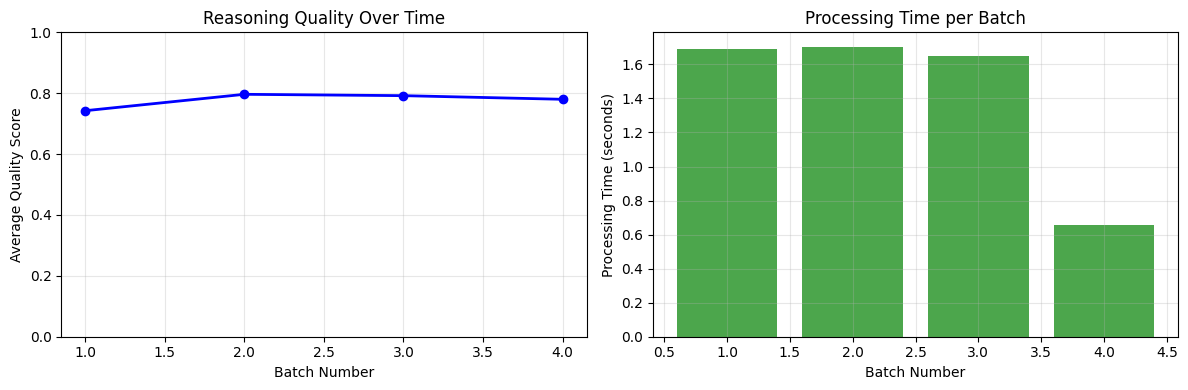

In [28]:
plot_progress(stats)